# Parallel model execution using `nums.sklearn`

This notebook aims to demonstrate the `nums.sklearn` module, which enables parallel training of scikit-learn models. 

For clarity, the form of parallelization offered by `nums.sklearn` differs from the block-partitioned scheme used by core NumS. Instead of parallelizing the computations on segments of the same multi-dimensional array, `nums.sklearn` parallelizes model execution, e.g. an ElasticNet and a GradientBoostingRegressor may be concurrently trained on separate cores. This will be referred to as coarse parallelism in the rest of this notebook.

The scalability demands of modern data science workloads can vary widely depending on the task. Some tasks involve computations on terabyte-scale datasets, which are addressed by NumS's BlockArray abstraction. On the other hand, tasks like model selection are not necessarily bottlenecked by huge array sizes, but they entail executing a large number of machine learning models, such as ones implemented in the scikit-learn library. scikit-learn only executes on a single core, so a remedy to this is coarse parallelism with `nums.sklearn`.

In this notebook, we showcase how to run a large scale data science task `much` faster using NumS. We will extract and preprocess data from the [GHCN-D dataset](https://registry.opendata.aws/noaa-ghcn/), which contains weather data collected from around the world for the past 2 centuries. From this dataset, we will perform model selection: put together time series data for a few specific stations and fit a large number of regression models to determine which model works the best. The GHCN-D dataset is >100 GB in total, and some intermediate computations are also cached in memory for performance reasons, so we don't recommend running this notebook on personal machines. The author's setup consists of 1 head and 2 worker nodes on AWS EC2, each being r5.16xlarge instances.

While not the main focus, this notebook will also make use of several other features of the NumS library like array manipulation and interoperability with Modin.

## Sections

[1. Imports and settings](#1)

[2. Data loading and preprocessing](#2)

[3. Model formulation](#3)

[4. Model search space](#4)

[5. Parallel model selection](#5)

<a id='1'></a>
## 1. Imports and settings

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os
import ray
from modin import pandas as pd
from nums import numpy as nps
from nums.core import settings
import nums
import boto3
from tqdm import tqdm

NumS uses the Ray distributed framework, hence we configure some cluster settings involving ray.

In [2]:
# Cluster settings
os.environ["RAY_IGNORE_UNHANDLED_ERRORS"] = "0" # Don't ignore errors
ray.init(ignore_reinit_error=True, address="auto") # On cluster
# ray.init() # On local machine
if len(ray.nodes()) > 1:
    settings.cluster_shape = (len(ray.nodes()) - 1, 1)
print(settings.cluster_shape)
nums.init()

2022-01-17 05:13:07,452	INFO worker.py:826 -- Connecting to existing Ray cluster at address: 10.0.0.198:6379


(1, 1)
Using driver node ip as head node.
head node 10.0.0.198
total cpus 64.0
device_grid (0, 0) 0=node:10.0.0.198/cpu:1


<a id='2'></a>
## 2. Data loading and preprocessing

We load the inventory table of year ranges for which a feature is available from a particular station.

In [3]:
# Global variables
all_years = list(range(1763, 2022))
local_path = "../ghcnd"
predictors = ["TMAX", "TMIN", "PRCP", "SNOW"] # Keep in same order

In [4]:
if local_path:
    stations = pd.read_fwf(f"{local_path}/ghcnd-stations.txt", widths=[12, 9, 10, 7, 3, 31, 4, 4, 6], header=None)
else:
    stations = pd.read_fwf("s3://noaa-ghcn-pds/ghcnd-stations.txt", widths=[12, 9, 10, 7, 3, 31, 4, 4, 6], header=None)
stations.columns = ["ID", "LATITUDE", "LONGITUDE", "ELEVATION", "STATE", "NAME", "GSN FLAG", "HCN/CRN FLAG", "WMO ID"]
ca_stations = stations[stations["STATE"] == "CA"]
print(len(ca_stations))
ca_stations.head()

2921


,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
56087,US1CAAL0001,37.8123,-122.2160,113.4,CA,PIEDMONT 1.0 SE,NaN,NaN,NaN
56088,US1CAAL0002,37.7075,-122.0687,87.5,CA,CASTRO VALLEY 0.5 WSW,NaN,NaN,NaN
56089,US1CAAL0003,37.7169,-122.0585,163.4,CA,CASTRO VALLEY 0.4 NNE,NaN,NaN,NaN
56090,US1CAAL0004,37.6483,-121.8745,107.0,CA,PLEASANTON 1.8 SSE,NaN,NaN,NaN
56091,US1CAAL0006,37.8319,-122.2503,58.2,CA,OAKLAND 4.4 NNW,NaN,NaN,NaN


In [5]:
ca_stations.loc[ca_stations["ID"] == "USC00040693"]

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
93290,USC00040693,37.8744,-122.2606,94.5,CA,BERKELEY,NaN,HCN,NaN


In [6]:
if local_path:
    inventory = pd.read_fwf(f"{local_path}/ghcnd-inventory.txt", widths=[12, 9, 10, 4, 5, 5], header=None, 
                            names=["ID", "LATITUDE", "LONGITUDE", "ELEMENT", "FIRSTYEAR", "LASTYEAR"])
else:
    inventory = pd.read_fwf("s3://noaa-ghcn-pds/ghcnd-inventory.txt", widths=[12, 9, 10, 4, 5, 5], header=None, 
                            names=["ID", "LATITUDE", "LONGITUDE", "ELEMENT", "FIRSTYEAR", "LASTYEAR"])
inventory.head()

,ID,LATITUDE,LONGITUDE,ELEMENT,FIRSTYEAR,LASTYEAR
0,ACW00011604,17.1167,-61.7833,TMAX,1949,1949
1,ACW00011604,17.1167,-61.7833,TMIN,1949,1949
2,ACW00011604,17.1167,-61.7833,PRCP,1949,1949
3,ACW00011604,17.1167,-61.7833,SNOW,1949,1949
4,ACW00011604,17.1167,-61.7833,SNWD,1949,1949


We define a function that loads the dataframe for a specific year from .csv data, then use it to load dataframes from all available years, caching them in a dictionary.

In [7]:
def data_loader(year, local_path=local_path):
    assert year in all_years
    if local_path:
        df = pd.read_csv(f"{local_path}/csv/{year}.csv", header=None, names=[
            "ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"
        ])
    else:
        df = pd.read_csv(f"s3://noaa-ghcn-pds/csv/{year}.csv", header=None, names=[
            "ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"
        ])
    # df.columns = ["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"]
    df["YEAR/MONTH/DAY"] = pd.to_datetime(df["YEAR/MONTH/DAY"], format="%Y%m%d")
    return df

year_dfs = {}
for year in tqdm(all_years):
    year_dfs[year] = data_loader(year).merge(ca_stations[["ID"]], on="ID", how="inner")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [08:17<00:00,  1.92s/it]


For each station, we create a time series dataframe. This involves selecting rows from all year_dfs with a matching station ID and element and appending them, with the date as the index.

In [8]:
%%time
def time_series(years_range, station_id, elements):
    assert isinstance(elements, list)
    df_elements = pd.DataFrame(columns=["DATA VALUE"])
    for year in range(years_range[0], years_range[1] + 1):
        df = year_dfs[year]
        df = df.loc[(df["ID"] == station_id) & (df["ELEMENT"].isin(elements))]
        
        if df_elements.empty:
            df_elements = df
        else:
            df_elements = df_elements.append(df)
        
    ts = pd.pivot_table(df_elements, values=["DATA VALUE"], index=["YEAR/MONTH/DAY"], columns=["ELEMENT"])
    
    # Impute missing values
    ts = ts.reindex(pd.date_range(ts.index.min(), ts.index.max()))
    ts = ts.groupby(ts.index.strftime('%b-%d')).transform(lambda g: g.fillna(g.mean()))
    # ts.index = ts.index.droplevel(0)
    return ts.reindex(elements, axis=1)
    
test_ts = time_series((1990, 2000), "USC00040693", ["TMAX", "TMIN", "PRCP", "SNOW"])
test_ts

CPU times: user 16.1 s, sys: 2.7 s, total: 18.8 s
Wall time: 14.4 s


,TMAX,TMIN,PRCP,SNOW
1990-01-01,111.0,72.0,224.0,0.0
1990-01-02,133.0,33.0,0.0,0.0
1990-01-03,122.0,39.0,0.0,0.0
1990-01-04,122.0,39.0,0.0,0.0
1990-01-05,139.0,50.0,0.0,0.0
...,...,...,...,...
2000-12-27,139.0,61.0,0.0,0.0
2000-12-28,150.0,56.0,0.0,0.0
2000-12-29,161.0,56.0,0.0,0.0
2000-12-30,156.0,50.0,0.0,0.0


Since a station may record different elements for different year ranges, we attempt to return a maximal time series for which records exist for all desired elements from the station.

In [9]:
def max_years_range(station_id, elements, min_range=20):
    start, end = 0, np.inf
    for el in elements:
        start = max(start, inventory[(inventory["ID"]==station_id) & (inventory["ELEMENT"]==el)]["FIRSTYEAR"].max())
        end = min(end, inventory[(inventory["ID"]==station_id) & (inventory["ELEMENT"]==el)]["LASTYEAR"].min())
    if start <= end - min_range + 1:
        return start, end
    return None

max_years_range("USC00040693", ["TMAX", "TMIN", "PRCP", "SNOW"])

(1899, 2010)

<a id='3'></a>
## 3. Model formulation

The function below constructs a multivariate AR design matrix $X$ from a time series. Specifically, to predict some element $y_i$ at day $i=t$, we use the set of predictor elements $X_i$ recorded at $i \in \{t-1, t-2, ..., t-p\}$, where the lag $p$ is a hyperparameter indicating how many past days will be included in our prediction model. This formulation is closely related to [autoregressive (AR) modeling](https://en.wikipedia.org/wiki/Autoregressive_model).

This function assumes the input parameters to be BlockArrays, and the reason for this will be explained later. For now, observe that BlockArray has a very similar interface as NumPy arrays, allowing us to transform a time series to a design matrix.

In [10]:
%%time

from nums import from_modin

def multivar_ar(days_range, tseries, p):
    """
    tseries is a BlockArray with all columns as predictor features, and first column is also the response
    """
    pred_series = tseries[days_range[0]:days_range[1]]
    series_len = pred_series.shape[0]
    pred_mat = nps.hstack([pred_series[i : series_len - p + i] for i in np.arange(p)])    
    resp_vec = pred_series[p:, 0].reshape(-1)
    return pred_mat, resp_vec

nps_ts = from_modin(test_ts.reset_index(drop=True)) # from_modin: DataFrame -> BlockArray
pred, resp = multivar_ar((0, None), nps_ts, 10)
print(pred.get())
print(resp.get())

[[111.  72. 224. ... 106.   0.   0.]
 [133.  33.   0. ...  94.   0.   0.]
 [122.  39.   0. ...  94. 396.   0.]
 ...
 [150.  67.   0. ...  56.   0.   0.]
 [161.  78.   0. ...  56.   0.   0.]
 [144.  50.   0. ...  50.   0.   0.]]
[156. 139. 128. ... 161. 156. 167.]
CPU times: user 680 ms, sys: 131 ms, total: 811 ms
Wall time: 533 ms


We define a standard RMSE function to be used during validation and testing.

In [11]:
def rmse(y, pred):
    if isinstance(y, np.ndarray):
        return np.sqrt(np.mean((pred - y) ** 2))
    else:
        return nps.sqrt(nps.mean((pred - y) ** 2))

We precompute the time series for the stations whose data we will analyze, convert them from DataFrames to BlockArrays, then cache the results. The goal of this is to take advantage NumS's asynchronous execution model by removing all blocking computation tasks during the model selection phase, as we shall seen soon.

In [12]:
from nums import from_modin

predictors = ["TMAX", "TMIN", "PRCP", "SNOW"]
response = "TMAX"
if response not in predictors:
    predictors.append(response)

# Cache all the time series for weather stations with enough data
station_tseries = {}
station_max_range = {}

# For now, just look at one station (USC00040693)
station_ids = ["USC00040693"]
for station_id in tqdm(station_ids):
    years_range = max_years_range(station_id, predictors)
    if years_range:
        station_max_range[station_id] = years_range
        tseries = time_series(station_max_range[station_id], station_id, predictors)
        station_tseries[station_id] = from_modin(tseries.reset_index(drop=True)) # from_modin: DataFrame -> BlockArray
print(f"Number of stations: {len(station_tseries)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:37<00:00, 157.65s/it]

Number of stations: 1


<a id='4'></a>
## 4. Model search space

For each station, we will search for the best combination of model and hyperparameters. 

The problem to be solved for each station is essentially the same: we want to find some regressor that best fits the previously defined design matrix $X$ to the data in $y$. We will try several popular regressors that are part of the scikit-learn library and supported in `nums.sklearn`, each with a small selection of hyperparameters. One additional hyperparameter is the lag $p$, interpreted as the number of past days we'd like to consider for predicting some variable of the upcoming day.

We use Python's named tuples to take advantange of the keyworded model parameters in the scikit-learn API, resulting in a clean way to iterate over our collection of models that each accept different parameters.

In [13]:
from itertools import product
from collections import namedtuple
from nums.sklearn import (
    train_test_split,
    ElasticNet,
    GradientBoostingRegressor, 
    RandomForestRegressor, 
    MLPRegressor, 
    SVR,
)

# Set up model selection parameters
ElasticNetP = namedtuple("ElasticNetP", "alpha l1_ratio")
GradientBoostingP = namedtuple("GradientBoostingP", "learning_rate n_estimators")
RandomForestP = namedtuple("RandomForestP", "n_estimators")
MLPP = namedtuple("MLPP", "hidden_layer_sizes")
SVRP = namedtuple("SVRP", "C epsilon")

Regressors = {
    ElasticNet: [ElasticNetP(*t) for t in product([0.2, 1.0], [0.0, 0.5, 1.0])],
    GradientBoostingRegressor: [GradientBoostingP(*t) for t in product([0.01, 0.1], [20, 100])],
    RandomForestRegressor: [RandomForestP(t) for t in [10, 50, 100]],
    MLPRegressor: [MLPP(t) for t in [(50,), (100,), (50, 50)]],
    SVR: [SVRP(*t) for t in product([0.2, 1.0], [0.1, 1])],
}

ps = [5, 10, 20, 50, 100]
num_regressors = sum(len(Regressors[k]) for k in Regressors)
print(f"Number of models per station: {num_regressors * len(ps)}")

Number of models per station: 100


<a id='5'></a>
## 5. Parallel model selection

Finally, we're at the main event! We will showcase how the `nums.sklearn` framework can train a large number of models in parallel on a cluster. This is crucial for boosting performance of workloads like model selection and pipelines that have little interdependence.

In the nested loops, we execute training and validation with every combination of (p, model, hyperparameters), and the combination with the lowest validation error is selected as the optimal model for that station. Note that we iterate through *p* in the outer loop because the design matrix is recomputed for every p, and we can't shuffle data points until a matrix is generated.

On setups with multiple cores, we observe that all the print statement logs below are displayed right away. This is because NumS uses Ray to asynchronously schedule each design matrix construction task (`multivar_ar`) and scikit-learn training task (`fit`/`predict`), with the awareness that the latter must wait for the former to complete. `get` blocks until a result is returned, so to maximize coarse parallelism, we only invoke it after the nested for loops (in `key=lambda...`).

In [14]:
from math import floor
import time

optimal_params = {}
validation_errors = {}

for station_id, tseries in station_tseries.items():
    # Split based on day 
    days_split = floor(0.8 * tseries.shape[0])
    
    validation_error = {}
    
    print(f"========Training started for {station_id}========")
    start_time = time.time()
    for p in ps:
        print(f"====Scheduling training processes with p={p}====")
        X_train, y_train = multivar_ar((0, days_split), tseries, p)
        X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.2) # Validation split
        
        for Regressor in list(Regressors.keys()):
            for model_params in Regressors[Regressor]:
                model = Regressor(**model_params._asdict())
                model.fit(X_t, y_t)
                y_pred = model.predict(X_v)
                v_err = rmse(y_v, y_pred)
                validation_error[(p, Regressor, model_params)] = v_err
                print(f"{station_id}: Validating {model_params}\tp={p}")

    optimal_params[station_id] = min(validation_error, key=lambda x: validation_error[x].get())
    validation_errors[station_id] = validation_error
    print(f"========Training ended for {station_id}========")
    print(f"Total training time for {station_id}: {time.time() - start_time}")

print(optimal_params)

========Training started for USC00040693========
====Scheduling training processes with p=5====
USC00040693: Validating ElasticNetP(alpha=0.2, l1_ratio=0.0)	p=5
USC00040693: Validating ElasticNetP(alpha=0.2, l1_ratio=0.5)	p=5
USC00040693: Validating ElasticNetP(alpha=0.2, l1_ratio=1.0)	p=5
USC00040693: Validating ElasticNetP(alpha=1.0, l1_ratio=0.0)	p=5
USC00040693: Validating ElasticNetP(alpha=1.0, l1_ratio=0.5)	p=5
USC00040693: Validating ElasticNetP(alpha=1.0, l1_ratio=1.0)	p=5
USC00040693: Validating GradientBoostingP(learning_rate=0.01, n_estimators=20)	p=5
USC00040693: Validating GradientBoostingP(learning_rate=0.01, n_estimators=100)	p=5
USC00040693: Validating GradientBoostingP(learning_rate=0.1, n_estimators=20)	p=5
USC00040693: Validating GradientBoostingP(learning_rate=0.1, n_estimators=100)	p=5
USC00040693: Validating RandomForestP(n_estimators=10)	p=5
USC00040693: Validating RandomForestP(n_estimators=50)	p=5
USC00040693: Validating RandomForestP(n_estimators=100)	p=5
USC0

On the author's setup, training each of the 100 models sequentially took 4346 seconds (about 1.2 hours), whereas it took <400 seconds (about 6.5 minutes) with the coarse parallelism enabled by `nums.sklearn`. In general, we expect significant performance boosts on any multicore system.

For the sake of completion, let us examine the results for one station, USC00040693 (can you guess which city?). We'll plot the predicted temperatures versus actual recorded temperatures for our testing year ranges.

========Testing started for USC00040693========
USC00040693: Tested GradientBoostingP(learning_rate=0.1, n_estimators=100)	p=100	score=24.84468961820531
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldObli

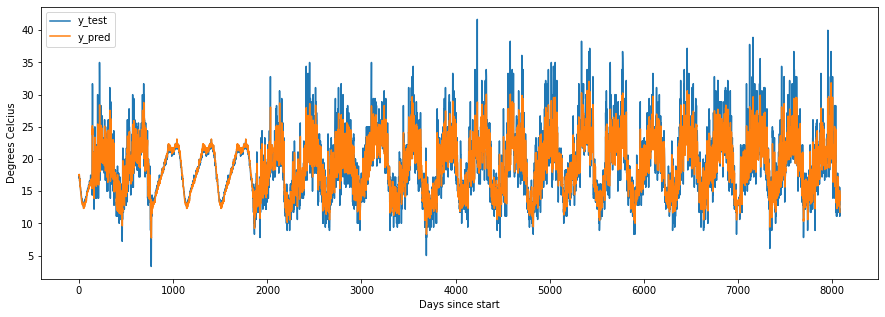

CPU times: user 4.94 s, sys: 527 ms, total: 5.47 s
Wall time: 1min 45s


In [15]:
%%time

test_scores = {}

station_id = "USC00040693"
tseries = station_tseries[station_id]

days_split = floor(0.8 * tseries.shape[0])

p, Regressor, model_params = optimal_params[station_id]
    
print(f"========Testing started for {station_id}========")
X_train, y_train = multivar_ar((0, days_split), tseries, p)
X_test, y_test = multivar_ar((days_split, None), tseries, p)
model = Regressor(**model_params._asdict())
model.fit(X_train.to_single_block(), y_train.to_single_block())
y_pred = model.predict(X_test.to_single_block())
t_err = rmse(y_test, y_pred)
test_scores[station_id] = t_err
print(f"{station_id}: Tested {model_params}\tp={p}\tscore={t_err.get()}")

plt.figure(figsize=(15, 5))
plt.plot(np.arange(y_test.size), (y_test.get() / 10), label="y_test")
plt.plot(np.arange(y_pred.size), (y_pred.get() / 10), label="y_pred")
plt.xlabel(f"Days since start")
plt.ylabel("Degrees Celcius")
plt.legend()
plt.show()

Because we only train and test a single model here, we don't observe the massive performance improvements from model selection.